In [1]:
import polars as pl
from plotnine import *

In [2]:
# cat shotgun_sra_20231208/* |jq -r '[.acc,.releasedate,.mbases,.organism] |@csv' |pigz >sra_metadata/sra_metadata_20230915.some_columns.csv.gz
# (miniforge3)cl5n006:20241101:~/git/sandpiper$ cat ~/m/big_data_microbiome/14_sra_metadata_20240520/shotgun_sra_20240523/* |jq -r '[.acc,.releasedate,.mbases,.organism] |@csv' |pigz >sra_metadata/shotgun_sra_20240523.some_columns.csv.gz
df = pl.read_csv('sra_metadata/shotgun_sra_20240523.some_columns.csv.gz', has_header=False)
df.columns = ['acc','releasedate','mbases','organism']
df[:4]

acc,releasedate,mbases,organism
str,str,i64,str
"""SRR29131140""","""2024-05-22T00:…",4986,"""soil metagenom…"
"""SRR29131143""","""2024-05-22T00:…",4096,"""soil metagenom…"
"""SRR29131156""","""2024-05-22T00:…",3988,"""soil metagenom…"
"""SRR29131146""","""2024-05-22T00:…",3403,"""soil metagenom…"


In [3]:
df = df.with_columns(pl.col('releasedate').str.slice(0,10).str.to_date("%Y-%m-%d"))
df[:4]

acc,releasedate,mbases,organism
str,date,i64,str
"""SRR29131140""",2024-05-22,4986,"""soil metagenom…"
"""SRR29131143""",2024-05-22,4096,"""soil metagenom…"
"""SRR29131156""",2024-05-22,3988,"""soil metagenom…"
"""SRR29131146""",2024-05-22,3403,"""soil metagenom…"


In [4]:
sum(df['mbases']) / 1_000_000 #=> This many terabases

3644.621887

In [5]:
df = df.with_columns(pl.date(year=pl.col('releasedate').dt.year(), month=pl.col('releasedate').dt.month(), day=1))
df[:4]
# per_month = df.groupby('releasedate').agg(pl.sum('mbases').alias('mbases'))

acc,releasedate,mbases,organism,date
str,date,i64,str,date
"""SRR29131140""",2024-05-22,4986,"""soil metagenom…",2024-05-01
"""SRR29131143""",2024-05-22,4096,"""soil metagenom…",2024-05-01
"""SRR29131156""",2024-05-22,3988,"""soil metagenom…",2024-05-01
"""SRR29131146""",2024-05-22,3403,"""soil metagenom…",2024-05-01


In [6]:
per_month = df.group_by('date').agg(pl.sum('mbases').alias('Gbp') / 1_000)
per_month_count = df.group_by('date').len()
per_month = per_month.join(per_month_count, on='date')
per_month[:4]

date,Gbp,len
date,f64,u32
2023-11-01,81669.616,10319
2016-09-01,3135.121,551
2021-05-01,43873.624,6876
2022-06-01,52939.679,9055


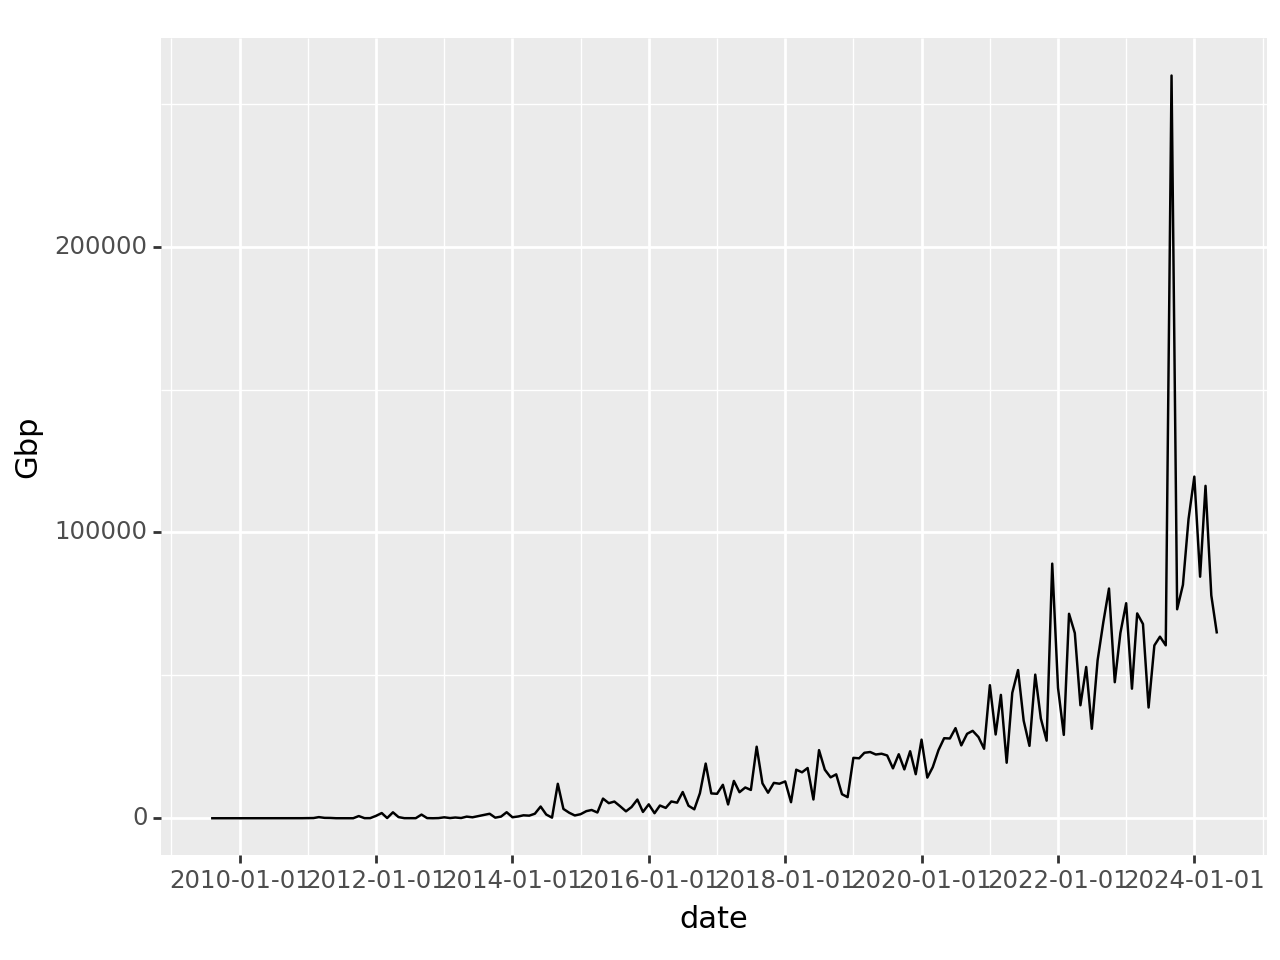

<Figure Size: (640 x 480)>

In [7]:
ggplot(per_month, aes(x='date', y='Gbp'))+geom_line() #+geom_smooth(colour='blue')

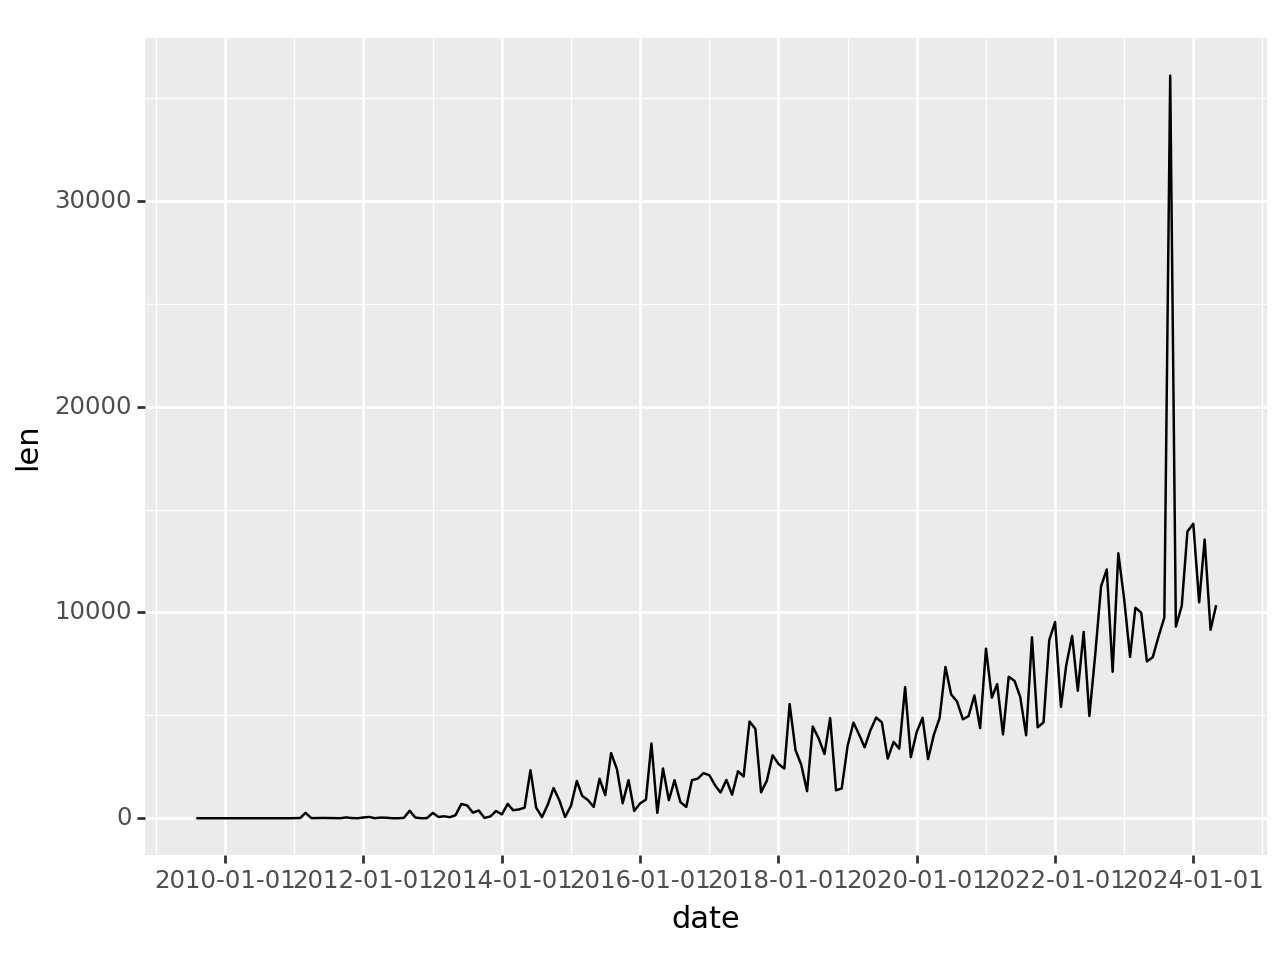

<Figure Size: (640 x 480)>

In [8]:
ggplot(per_month, aes(x='date', y='len'))+geom_line() #+geom_smooth(colour='blue')

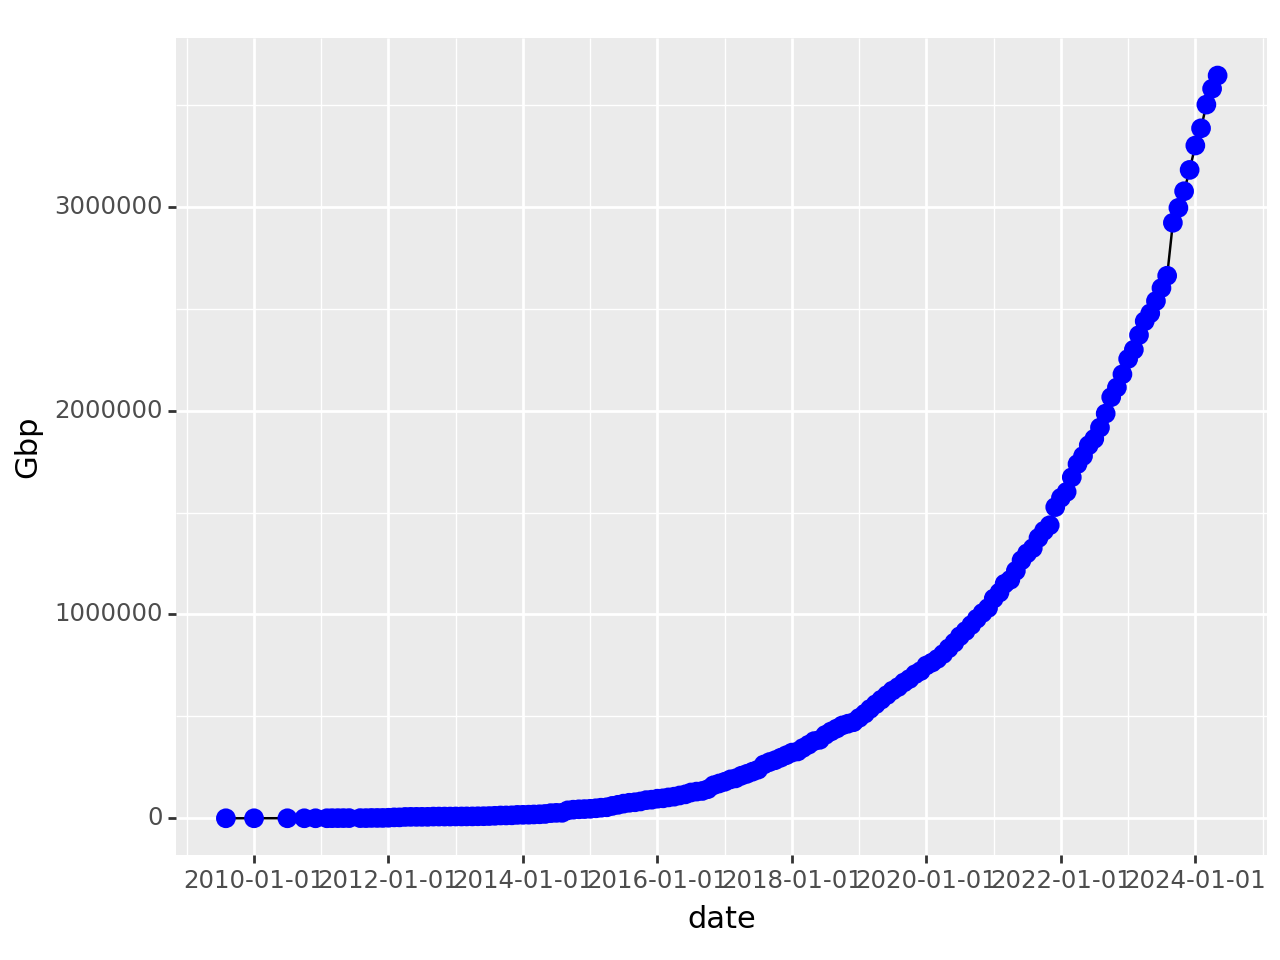

<Figure Size: (640 x 480)>

In [9]:
perm_month_cumulative = per_month.sort('date').with_columns([
    pl.col('Gbp').cum_sum(),
    pl.col('len').cum_sum()
])
ggplot(perm_month_cumulative, aes(x='date', y='Gbp'))+geom_line()+geom_point(size=3, colour='blue') #+geom_smooth(colour='blue')

shape: (3, 4)
┌──────┬──────────┬─────┬──────────┐
│ date ┆ Gbp      ┆ len ┆ Tbp      │
│ ---  ┆ ---      ┆ --- ┆ ---      │
│ i32  ┆ f64      ┆ u32 ┆ f64      │
╞══════╪══════════╪═════╪══════════╡
│ 2009 ┆ 7.653    ┆ 2   ┆ 0.007653 │
│ 2010 ┆ 45.144   ┆ 8   ┆ 0.045144 │
│ 2011 ┆ 1689.433 ┆ 381 ┆ 1.689433 │
└──────┴──────────┴─────┴──────────┘


/home/woodcrob/e/mybase/lib/python3.11/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



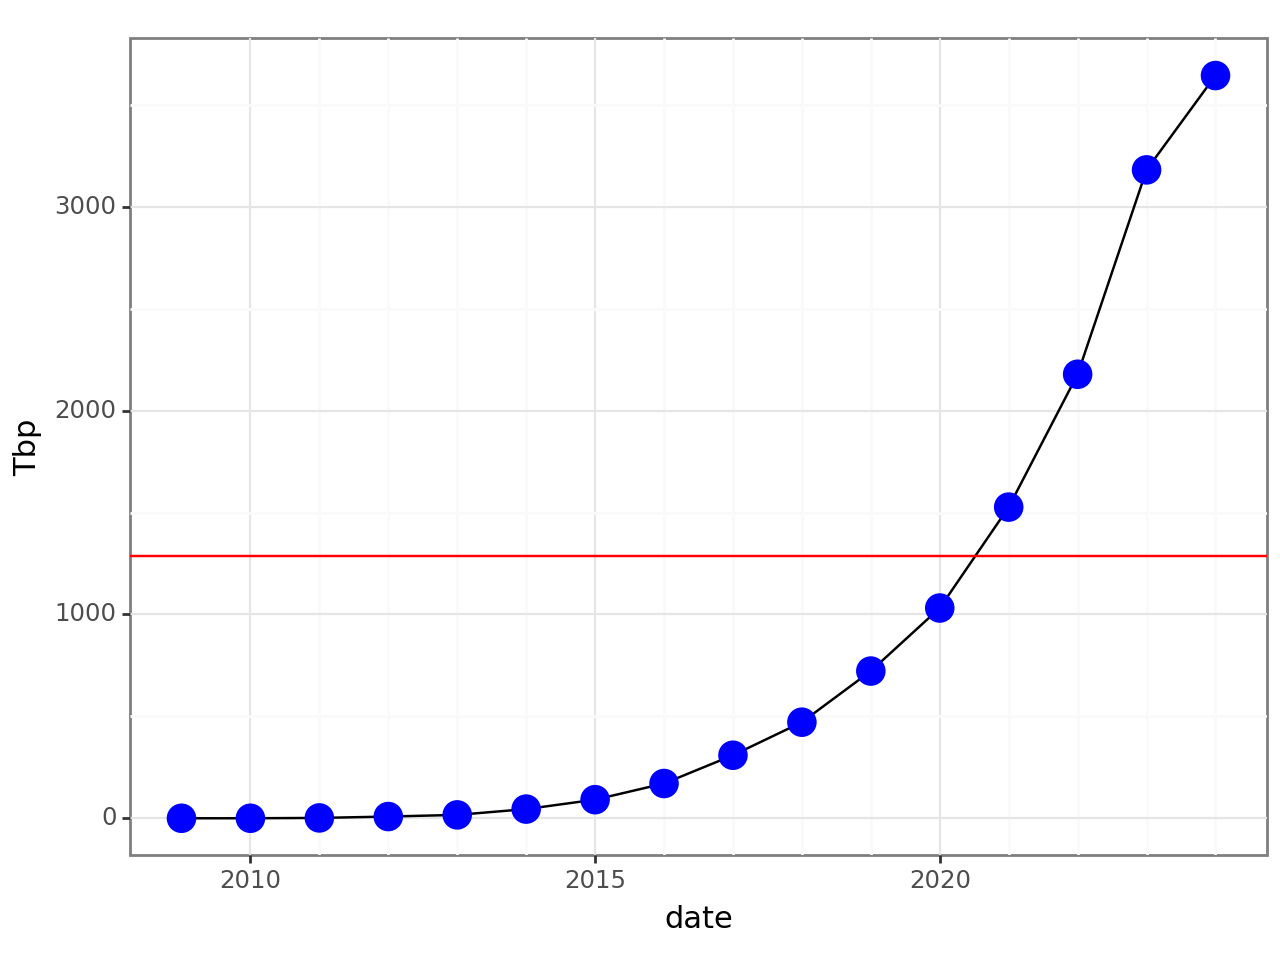

<Figure Size: (640 x 480)>

In [10]:
per_year = df.with_columns(pl.col('releasedate').dt.year().alias('date')).group_by('date').agg(pl.sum('mbases').alias('Gbp') / 1_000)
per_year_count = df.with_columns(pl.col('releasedate').dt.year().alias('date')).group_by('date').len()
per_year = per_year.join(per_year_count, on='date')
per_year_cumulative = per_year.sort('date').with_columns([
    pl.col('Gbp').cum_sum(),
    pl.col('len').cum_sum()
])
per_year_cumulative = per_year_cumulative.with_columns((pl.col('Gbp') / 1000).alias('Tbp'))
print(per_year_cumulative.head(3))
ggplot(per_year_cumulative, aes(x='date', y='Tbp'))+geom_line()+geom_point(size=5, colour='blue')+xlim([2012,max(per_year['date'])])+theme_bw()+geom_hline(yintercept=1287,colour='red')+scale_x_continuous(
    breaks=range(2010,max(per_year['date'])+1,5),
    minor_breaks=range(2010,max(per_year['date'])+1,1))

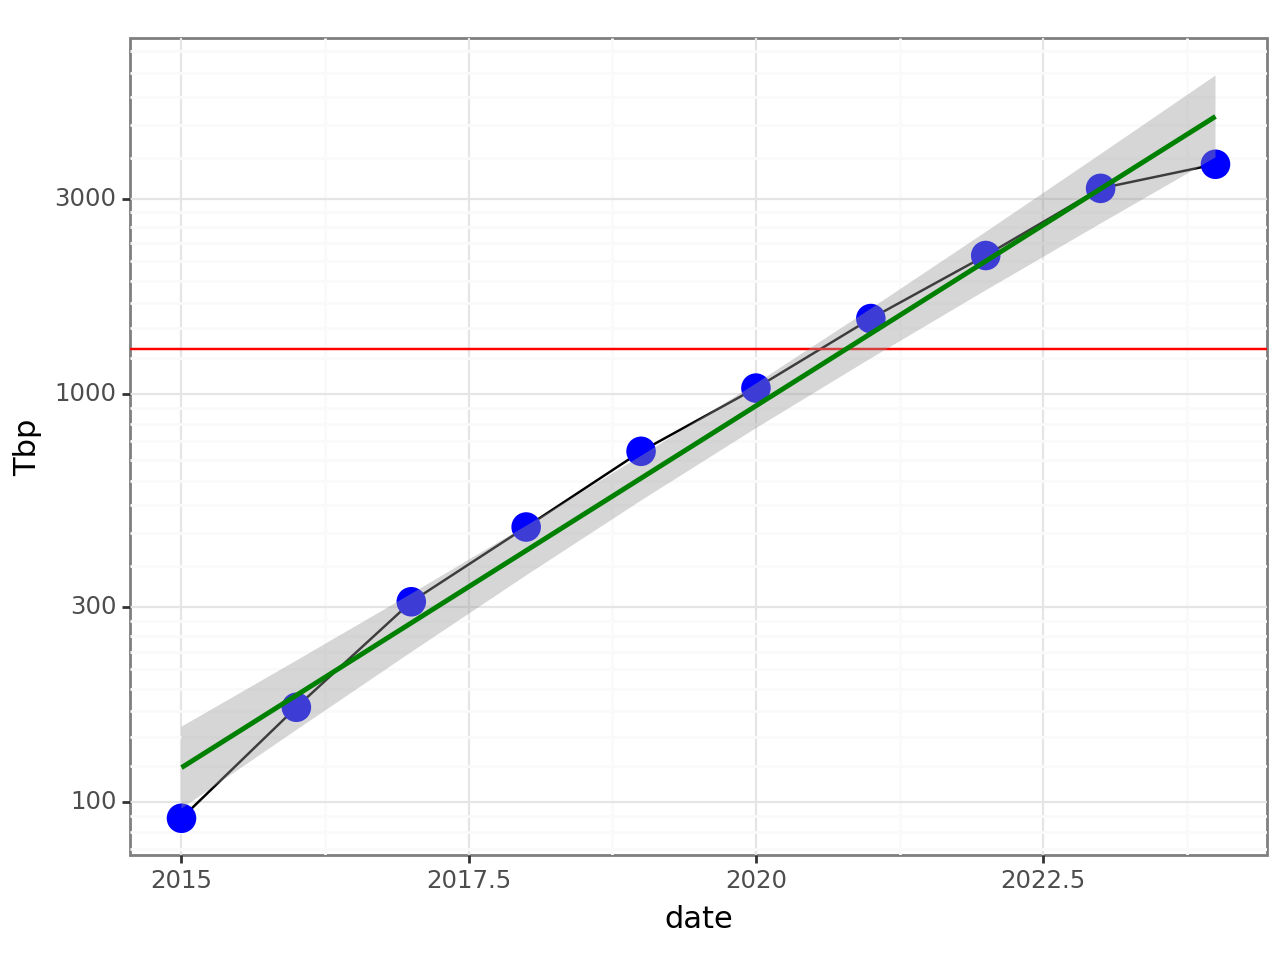

<Figure Size: (640 x 480)>

In [11]:
ggplot(per_year_cumulative.filter(pl.col('date')>2014), aes(x='date', y='Tbp'))+geom_line()+geom_point(size=5, colour='blue')+theme_bw()+geom_hline(yintercept=1287,colour='red')+scale_x_continuous(
    # breaks=range(2010,max(per_year['date'])+1,5),
    # minor_breaks=range(2010,max(per_year['date'])+1,1)
    )+scale_y_log10()+geom_smooth(method='lm', colour='green')

597.77


/home/woodcrob/e/mybase/lib/python3.11/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/home/woodcrob/e/mybase/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4 x 3 in image.
/home/woodcrob/e/mybase/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: metagenome_count_per_year.png


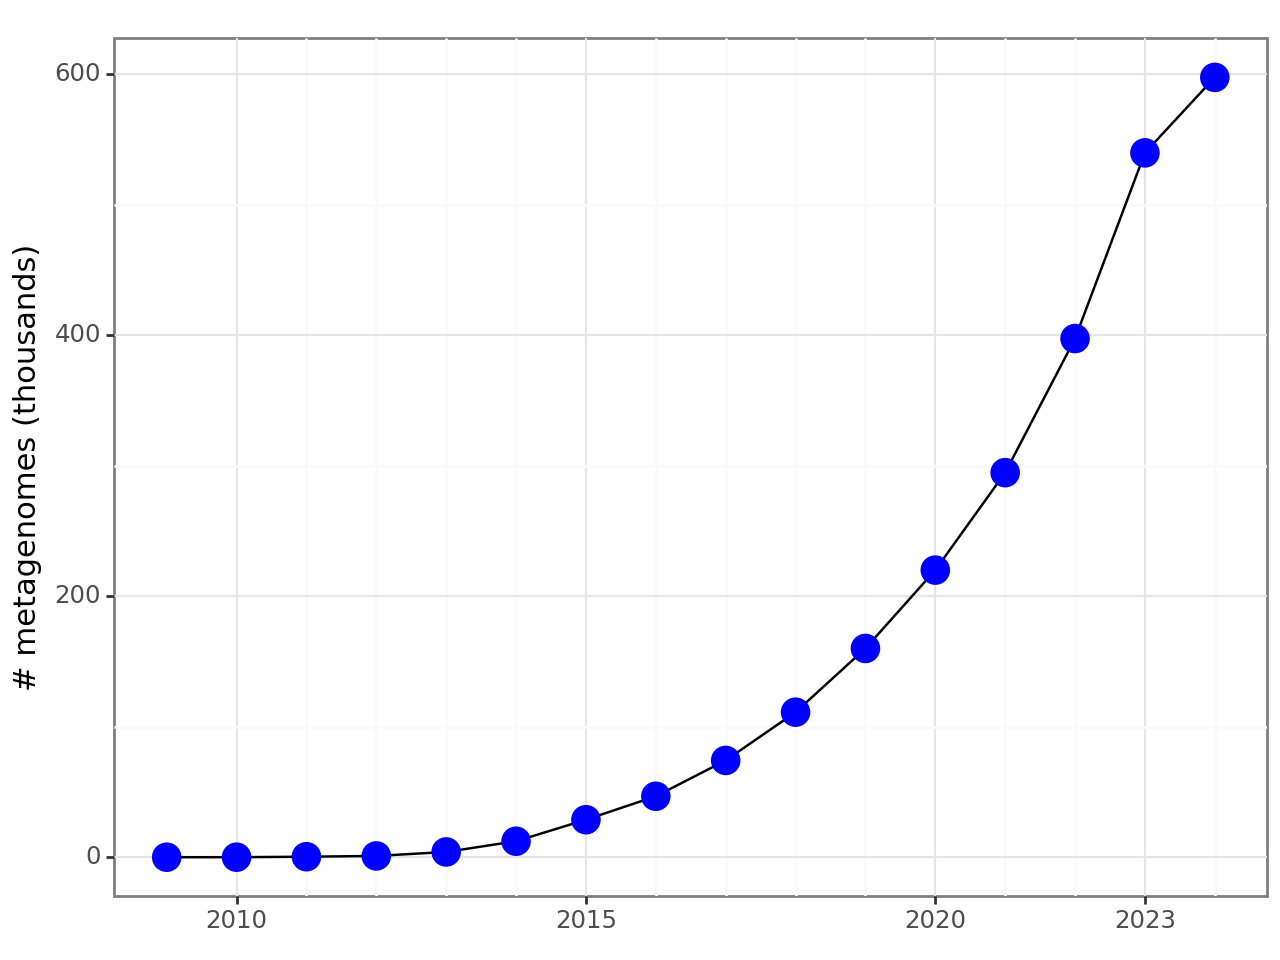

<Figure Size: (640 x 480)>

In [18]:
per_year_cumulative = per_year_cumulative.with_columns(pl.col('len').alias('thousands of metagenomes')/1000)
print(per_year_cumulative.select(pl.col('thousands of metagenomes').max())[0,0])
p = ggplot(per_year_cumulative, aes(x='date', y='thousands of metagenomes'))+geom_line()+geom_point(size=5, colour='blue')+xlim([2012,max(per_year['date'])])+theme_bw()+scale_x_continuous(
    breaks=list(range(2010,max(per_year['date'])+1,5))+[2023],
    minor_breaks=range(2010,max(per_year['date'])+1,1))+\
    theme(axis_title_x=element_blank())+ylab('# metagenomes (thousands)')
p.save('metagenome_count_per_year.png', height=3, width=4)
p

In [13]:
def show_all(df, width=200, max_col_width=True):
    '''
    Prints an entire polars dataframe in the console or notebook output.
    Parameters
    ----------
    df : pl.DataFrame
        The dataframe to be printed.
    width : int, optional
        The width of the printed dataframe.
        Defaults to 200.
    max_col_width : bool, optional
        Whether to set the maximum column width.
        i.e. it will print the full contents of the cells.
        Defaults to True.
    '''
    with  pl.Config()  as  cfg:
        cfg.set_tbl_cols(-1)
        cfg.set_tbl_rows(-1)
        cfg.set_tbl_width_chars(width)
        if  max_col_width  or  len(df.columns) ==  1:
            cfg.set_fmt_str_lengths(width)
        print(df)

In [14]:
# Spike in submissions - what was it?
per_month.sort('Gbp', descending=True)[:5]
# September 2023 - 260 Gbp in a month   ..
df.filter(pl.col('date') == pl.date(2023,9,1)).sample(20)
show_all(df.filter(pl.col('date') == pl.date(2023,9,1)).group_by('organism').len().sort('len', descending=True)[:10]) #human gut metagenome 14k samples
# show_all(df.filter(pl.col('date') == pl.date(2023,9,1)).filter(pl.col('organism') == 'human gut metagenome').sample(10))
df.filter(pl.col('date') == pl.date(2023,9,1)).filter(pl.col('organism') == 'human gut metagenome').group_by('releasedate').len().sort('len', descending=True)[:10] # 2023-09-16 6k metagenomes
df.filter(pl.col('releasedate') == pl.date(2023,9,16)).sample(10)
# Human gut metagenomes of SCAPIS Uppsala and Malmo. 9000 faceal samples or something. Pretty large study..

shape: (10, 2)
┌────────────────────────┬───────┐
│ organism               ┆ len   │
│ ---                    ┆ ---   │
│ str                    ┆ u32   │
╞════════════════════════╪═══════╡
│ human gut metagenome   ┆ 14402 │
│ marine metagenome      ┆ 4838  │
│ metagenome             ┆ 3320  │
│ unidentified           ┆ 2069  │
│ human oral metagenome  ┆ 1885  │
│ human feces metagenome ┆ 1610  │
│ Pseudomonas aeruginosa ┆ 1049  │
│ soil metagenome        ┆ 757   │
│ mouse gut metagenome   ┆ 729   │
│ gut metagenome         ┆ 653   │
└────────────────────────┴───────┘


acc,releasedate,mbases,organism,date
str,date,i64,str,date
"""ERR11564004""",2023-09-16,6426,"""human gut meta…",2023-09-01
"""ERR11509665""",2023-09-16,5290,"""human feces me…",2023-09-01
"""ERR11458080""",2023-09-16,8598,"""human gut meta…",2023-09-01
"""ERR11564770""",2023-09-16,7569,"""human gut meta…",2023-09-01
"""ERR11566398""",2023-09-16,8861,"""human gut meta…",2023-09-01
"""ERR11509493""",2023-09-16,6557,"""human feces me…",2023-09-01
"""ERR11569151""",2023-09-16,9438,"""human gut meta…",2023-09-01
"""ERR11564991""",2023-09-16,7446,"""human gut meta…",2023-09-01
"""ERR11504254""",2023-09-16,6393,"""human gut meta…",2023-09-01
